# 07__motif_coverage
# analyzing how motif coverage correlates with MPRA properties and biotypes; clustering similar motifs

in this notebook, i look at how the coverage metrics (# bp covered and max coverage of motifs; done separately, see methods) look within biotypes *after* limiting to only those motifs which have been validated by a corresponding chip peak. i also make sure the results we see aren't due to redundancies in motif databases, so i cluster the motifs using MoSBAT (done separately using their webtool) and re-calculate the metrics.

------

figures in this notebook:
- **Fig 2D and 2E**: cumulative density plots of # bp covered and max motif coverage across biotypes
- **Fig S7**: heatmap of clustered motifs, and more cumulative density plots (after clustering)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from random import shuffle
from scipy import stats
from scipy import signal
from scipy.spatial import distance
from scipy.cluster import hierarchy
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
mosbat_file = "../../misc/02__mosbat/results.from_mosbat.txt"

In [4]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.uniq.bed"
cage_expr_f = "../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"

In [5]:
fimo_cov_f = "../../data/04__coverage/all_fimo_map.all_cov.new.txt"
fimo_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersected.all_cov.new.txt"
fimo_clust_cov_f = "../../data/04__coverage/all_fimo_map.bulyk_clusters.all_cov.new.txt"
fimo_no_ets_cov_f = "../../data/04__coverage/all_fimo_map.no_ETS_motifs.all_cov.new.txt"
fimo_no_ets_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersected.no_ETS_motifs.all_cov.new.txt"

pool1_fimo_cov_f = "../../data/04__coverage/pool1_fimo_map.all_cov.new.txt"
pool1_fimo_chip_cov_f = "../../data/04__coverage/all_fimo_map.chip_intersectedall_cov.new.txt"

In [6]:
fimo_phylop_f = "../../misc/03__fimo/03__phylop_meta_plot/all_fimo_map.phylop46way.txt"
fimo_chip_phylop_f = "../../misc/03__fimo/03__phylop_meta_plot/all_fimo_map.chip_intersected.phylop46way.txt"
fimo_clust_phylop_f = "../../misc/03__fimo/03__phylop_meta_plot/all_fimo_map.bulyk_clusters.phylop46way.txt"

In [7]:
all_phylop_f = "../../data/00__index/0__all_tss/All.TSS.114bp.uniq.phylop46way.txt"

note: the reason why some IDs are not in the expression file is these are FANTOM CAT IDs that for some reason are not present in the FANTOM5 robust set. so, we exclude these.

## 1. import data

In [8]:
corr = pd.read_table(mosbat_file, sep="\t")

In [9]:
all_phylop = pd.read_table(all_phylop_f, sep="\t")
all_phylop.columns = ["chr", "start", "end", "unique_id", "score", "strand", "size", "num_data", "min", "max",
                      "mean", "median"]
all_phylop.head()

,chr,start,end,unique_id,score,strand,size,num_data,min,max,mean,median
0,chr10,100027916,100028031,protein_coding__p1@LOXL4__chr10:100027943..100...,0,-,115,115,-3.70,2.09,0.26,0.09
1,chr10,100074495,100074610,Enhancer__chr10:100074404-100074582,0,+,115,115,-2.46,2.73,0.66,0.49
2,chr10,100076068,100076183,Enhancer__chr10:100076038-100076149,0,+,115,115,-3.45,2.18,-0.27,-0.14
3,chr10,100076605,100076720,Enhancer__chr10:100076500-100076699,0,+,115,115,-2.98,2.41,0.18,0.21
4,chr10,100083158,100083273,Enhancer__chr10:100082942-100083374,0,+,115,115,-2.89,2.36,-0.05,-0.03


In [10]:
fimo_phylop = pd.read_table(fimo_phylop_f, sep="\t", header=None)
cols = ["chr", "start", "end", "motif", "n_ov", "tss_dist"]
cols.extend(np.arange(-150, 150, step=1))
fimo_phylop.columns = cols

In [11]:
fimo_chip_phylop = pd.read_table(fimo_chip_phylop_f, sep="\t", header=None)
fimo_chip_phylop.columns = cols

In [12]:
fimo_clust_phylop = pd.read_table(fimo_clust_phylop_f, sep="\t", header=None)
fimo_clust_phylop.columns = cols

In [13]:
fimo_cov = pd.read_table(fimo_cov_f, sep="\t")
fimo_chip_cov = pd.read_table(fimo_chip_cov_f, sep="\t")
fimo_clust_cov = pd.read_table(fimo_clust_cov_f, sep="\t")
fimo_no_ets_cov = pd.read_table(fimo_no_ets_cov_f, sep="\t")
fimo_no_ets_chip_cov = pd.read_table(fimo_no_ets_chip_cov_f, sep="\t")
fimo_chip_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp
5021,"div_lnc__NA__chr11:832845..832892,-","chr11:832845..832892,-",18,68,3,0.514773,2.944439,4.234107,1.386294,0.415266
17473,protein_coding__p1@ATG4D__chr19:10654561..1065...,"chr19:10654561..10654600,+",22,78,7,0.384321,3.135494,4.369448,2.079442,0.325210
26496,intergenic__p1@ENST00000450500__chr3:177652390...,"chr3:177652390..177652395,+",2,24,1,0.585164,1.098612,3.218876,0.693147,0.460688
13273,Enhancer__chr16:30458943-30459145,chr16:30458943-30459145,3,36,1,0.398015,1.386294,3.610918,0.693147,0.335053
7682,Enhancer__chr12:52525424-52525587,chr12:52525424-52525587,2,17,2,0.561240,1.098612,2.890372,1.098612,0.445480


In [14]:
print(len(fimo_cov))
print(len(fimo_chip_cov))
print(len(fimo_clust_cov))

56578
40375
35108


In [15]:
fimo_cov["PromType2"] = fimo_cov["unique_id"].str.split("__", expand=True)[0]
fimo_chip_cov["PromType2"] = fimo_chip_cov["unique_id"].str.split("__", expand=True)[0]
fimo_clust_cov["PromType2"] = fimo_clust_cov["unique_id"].str.split("__", expand=True)[0]
fimo_no_ets_cov["PromType2"] = fimo_no_ets_cov["unique_id"].str.split("__", expand=True)[0]
fimo_no_ets_chip_cov["PromType2"] = fimo_no_ets_chip_cov["unique_id"].str.split("__", expand=True)[0]
fimo_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2
37217,Enhancer__chr3:32836613-32836654,chr3:32836613-32836654,19,77,10,0.335776,2.995732,4.356709,2.397895,0.289512,Enhancer
7754,Enhancer__chr1:206921953-206922243,chr1:206921953-206922243,32,96,10,0.465612,3.496508,4.574711,2.397895,0.382273,Enhancer
37848,"div_pc__p5@ARHGEF3__chr3:57113314..57113350,-","chr3:57113314..57113350,-",77,111,26,0.411153,4.356709,4.718499,3.295837,0.344407,div_pc
53095,Enhancer__chr9:117345821-117345927,chr9:117345821-117345927,22,60,11,0.414216,3.135494,4.110874,2.484907,0.346575,Enhancer
28383,protein_coding__p1@GATA5__chr20:61051039..6105...,"chr20:61051039..61051057,-",20,58,11,0.383244,3.044522,4.077537,2.484907,0.324432,protein_coding


In [16]:
# filter to those that have at least 1 motif so distributions are not 0-skewed
fimo_cov = fimo_cov[fimo_cov["n_motifs"] > 0]
print(len(fimo_cov))

fimo_chip_cov = fimo_chip_cov[fimo_chip_cov["n_motifs"] > 0]
print(len(fimo_chip_cov))

fimo_no_ets_cov = fimo_no_ets_cov[fimo_no_ets_cov["n_motifs"] > 0]
print(len(fimo_no_ets_cov))

fimo_no_ets_chip_cov = fimo_no_ets_chip_cov[fimo_no_ets_chip_cov["n_motifs"] > 0]
print(len(fimo_no_ets_chip_cov))

fimo_clust_cov = fimo_clust_cov[fimo_clust_cov["n_motifs"] > 0]
print(len(fimo_clust_cov))

56578
40373
56571
39607
35092


In [17]:
cage_expr = pd.read_table(cage_expr_f, sep="\t")
cage_expr.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,moderate
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,moderate
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


In [18]:
fimo_cov = fimo_cov.merge(cage_expr, on="cage_id", how="left")
fimo_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",19,66,7,0.452439,2.995732,4.204693,2.079442,0.373244,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100074404-100074582,chr10:100074404-100074582,26,91,9,0.498479,3.295837,4.521789,2.302585,0.404451,Enhancer,0.015866,0.993289,0.666667,31.0,tissue-specific
2,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,25,78,8,0.338257,3.258097,4.369448,2.197225,0.291368,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
3,Enhancer__chr10:100076500-100076699,chr10:100076500-100076699,21,89,8,0.394609,3.091042,4.499810,2.197225,0.332614,Enhancer,0.029745,0.981128,NaN,67.0,moderate
4,Enhancer__chr10:100082942-100083374,chr10:100082942-100083374,36,93,13,0.375421,3.610918,4.543295,2.639057,0.318760,Enhancer,0.023984,0.986789,0.666667,47.0,tissue-specific


In [19]:
fimo_chip_cov = fimo_chip_cov.merge(cage_expr, on="cage_id", how="left")
fimo_chip_cov.sample(5)

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
7132,Enhancer__chr1:234659231-234659760,chr1:234659231-234659760,6,33,2,0.384087,1.945910,3.526361,1.098612,0.325040,Enhancer,0.329826,0.967198,0.606373,245.0,moderate
26574,Enhancer__chr3:184458237-184458578,chr3:184458237-184458578,2,25,1,0.631935,1.098612,3.258097,0.693147,0.489766,Enhancer,NaN,NaN,NaN,NaN,NaN
36230,"intergenic__NA__chr8:126762486..126762506,-","chr8:126762486..126762506,-",7,64,2,0.205514,2.079442,4.174387,1.098612,0.186906,intergenic,NaN,NaN,NaN,NaN,NaN
27175,Enhancer__chr3:46425104-46425266,chr3:46425104-46425266,1,21,1,0.421290,0.693147,3.091042,0.693147,0.351565,Enhancer,NaN,NaN,NaN,NaN,NaN
14821,"protein_coding__p1@DOC2B__chr17:31432..31473,-","chr17:31432..31473,-",4,25,3,0.327989,1.609438,3.258097,1.386294,0.283666,protein_coding,7.488096,0.940111,0.666667,322.0,moderate


In [20]:
fimo_clust_cov = fimo_clust_cov.merge(cage_expr, on="cage_id", how="left")
fimo_clust_cov.head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,log_n_motifs,log_bp_cov,log_max_cov,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,protein_coding__p1@LOXL4__chr10:100027943..100...,"chr10:100027943..100027958,-",10,67,3,2.397895,4.219508,1.386294,protein_coding,5.375834,0.968756,0.666667,346.0,moderate
1,Enhancer__chr10:100076038-100076149,chr10:100076038-100076149,1,13,1,0.693147,2.639057,0.693147,Enhancer,0.022990,0.995153,NaN,24.0,tissue-specific
2,protein_coding__p1@PYROXD2__chr10:100174900..1...,"chr10:100174900..100174956,-",4,39,1,1.609438,3.688879,0.693147,protein_coding,5.764484,0.872210,0.547032,508.0,ubiquitous
3,protein_coding__p1@HPS1__chr10:100206642..1002...,"chr10:100206642..100206717,-",11,63,4,2.484907,4.158883,1.609438,protein_coding,30.877938,0.777160,0.192167,546.0,ubiquitous
4,protein_coding__p1@HPSE2__chr10:100995440..100...,"chr10:100995440..100995474,-",12,49,5,2.564949,3.912023,1.791759,protein_coding,0.639976,0.966872,NaN,142.0,moderate


In [21]:
chip_cov_exp = fimo_chip_cov[~pd.isnull(fimo_chip_cov["av_exp"])]
motif_cov_exp = fimo_cov[~pd.isnull(fimo_cov["av_exp"])]
cluster_cov_exp = fimo_clust_cov[~pd.isnull(fimo_clust_cov["av_exp"])]

In [22]:
motif_cov_exp.PromType2.value_counts()

Enhancer          17866
protein_coding    13441
intergenic         1531
div_pc             1302
div_lnc             674
antisense           622
Name: PromType2, dtype: int64

In [23]:
chip_cov_exp.PromType2.value_counts()

Enhancer          13539
protein_coding    11988
div_pc             1255
intergenic         1082
div_lnc             652
antisense           447
Name: PromType2, dtype: int64

In [24]:
cluster_cov_exp.PromType2.value_counts()

protein_coding    13016
Enhancer           5457
intergenic         1405
div_pc             1278
div_lnc             665
antisense           586
Name: PromType2, dtype: int64

## 2. plot # bp covered & max cov across biotypes

### all motifs

(2, 5)

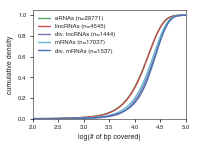

In [25]:
enh_vals = fimo_cov[fimo_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_cov[fimo_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_cov[fimo_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_cov[fimo_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_cov[fimo_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
ax.set_xlim((2, 5))

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 4.91980164211e-07
ub/dy pval: 0.00173371418102
ts/dy pval: 0.00263441209912
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.41724647984e-10
ub/dy pval: 9.98152790154e-07
ts/dy pval: 0.191616400886
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 2.87474407868e-78
ub/dy pval: 3.38741914737e-37
ts/dy pval: 0.0818091408358


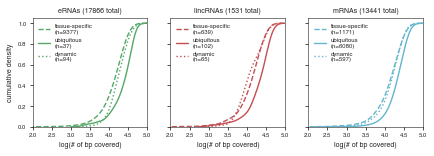

In [26]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-specific\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiquitous\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="upper left")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

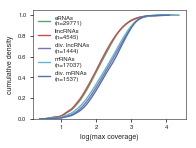

In [27]:
enh_vals = fimo_cov[fimo_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_cov[fimo_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_cov[fimo_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_cov[fimo_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_cov[fimo_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
ax.legend(loc="upper left")
fig.savefig("max_cov.all_biotypes.for_poster.pdf", dpi="figure", bbox_inches="tight")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 4.68343437712e-07
ub/dy pval: 6.32303148491e-05
ts/dy pval: 0.854221458313
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.53038871983e-09
ub/dy pval: 0.000205505597365
ts/dy pval: 0.940596763506
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 7.9111064673e-101
ub/dy pval: 4.66388592798e-52
ts/dy pval: 0.438947388615


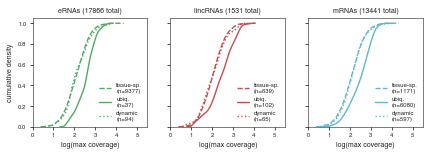

In [28]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = motif_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 5.5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")

### ChIP-validated motifs

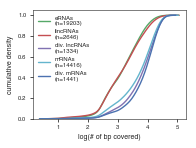

In [29]:
enh_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2D.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 5.50890959758e-19
ub/dy pval: 1.24059535023e-11
ts/dy pval: 0.484897802464
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 1.14164835065e-33
ub/dy pval: 1.70901071181e-11
ts/dy pval: 0.828499564258
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 3.72983909368e-270
ub/dy pval: 6.92755327834e-156
ts/dy pval: 0.0120970126181


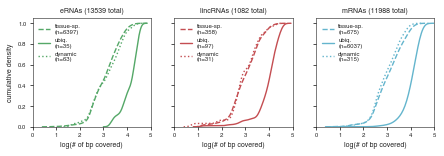

In [30]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (0, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2D_biotype_split.pdf", bbox_inches="tight", dpi="figure")

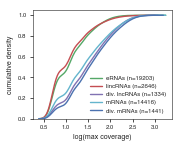

In [31]:
enh_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_chip_cov[fimo_chip_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.5, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2E.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 1.86333912097e-18
ub/dy pval: 1.13038718841e-11
ts/dy pval: 0.572371468134
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 2.31807445622e-33
ub/dy pval: 7.469166141e-09
ts/dy pval: 0.344277214738
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 4.14794678834e-246
ub/dy pval: 5.88267147348e-129
ts/dy pval: 0.636478500335


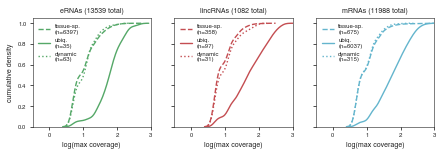

In [32]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = chip_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (-0.5, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2E_biotype_split.pdf", bbox_inches="tight", dpi="figure")

### clustered motifs

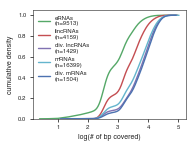

In [33]:
enh_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "Enhancer"]["log_bp_cov"]
linc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "intergenic"]["log_bp_cov"]
dlnc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_lnc"]["log_bp_cov"]
pc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "protein_coding"]["log_bp_cov"]
dpc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_pc"]["log_bp_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs\n(n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs\n(n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs\n(n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs\n(n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs\n(n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2D_clusters.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 0.210409326737
ub/dy pval: 0.635933482817
ts/dy pval: 0.374418946433
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 2.51198813772e-17
ub/dy pval: 2.68578952343e-08
ts/dy pval: 0.635701050858
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 5.25599122169e-166
ub/dy pval: 2.87139600476e-95
ts/dy pval: 0.516340164884


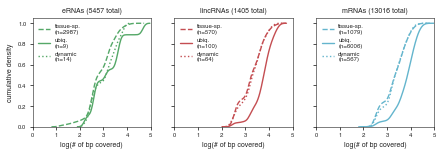

In [34]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_bp_cov"
xlabel = "log(# of bp covered)"
xlim = (0, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2D_clusters_biotype_split.pdf", bbox_inches="tight", dpi="figure")

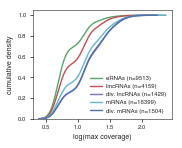

In [35]:
enh_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = fimo_clust_cov[fimo_clust_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.5, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_2E_clusters.pdf", bbox_inches="tight", dpi="figure")

i: 0, promtype: Enhancer, name: eRNAs
ub/ts pval: 0.0156136374621
ub/dy pval: 0.172366647173
ts/dy pval: 0.486219965444
i: 1, promtype: intergenic, name: lincRNAs
ub/ts pval: 8.68761151491e-15
ub/dy pval: 0.000169326426739
ts/dy pval: 0.125699377831
i: 2, promtype: protein_coding, name: mRNAs
ub/ts pval: 7.46341928537e-97
ub/dy pval: 5.05740970401e-56
ts/dy pval: 0.740894975681


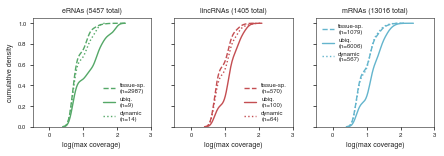

In [36]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (-0.5, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    ub_ts_u, ub_ts_pval = stats.mannwhitneyu(ub_vals, ts_vals, alternative="two-sided", use_continuity=False)
    print("ub/ts pval: %s" % ub_ts_pval)
    
    ub_dy_u, ub_dy_pval = stats.mannwhitneyu(ub_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ub/dy pval: %s" % ub_dy_pval)
    
    ts_dy_u, ts_dy_pval = stats.mannwhitneyu(ts_vals, dy_vals, alternative="two-sided", use_continuity=False)
    print("ts/dy pval: %s" % ts_dy_pval)
    
    sns.kdeplot(data=ts_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, bw=0.1, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_2E_clusters_biotype_split.pdf", bbox_inches="tight", dpi="figure")

## 2. cluster the motifs using MoSBAT output

In [37]:
corr.set_index(corr["Motif"], inplace=True)
corr.drop("Motif", axis=1, inplace=True)
corr.head()

,RUNX1,TFAP2A,Arnt,Ahr..Arnt,Ar,T,PAX5,NR2F1,CREB1,Ddit3..Cebpa,...,HOXC12,HOXC13,HOXD11,HOXD13,Hoxd8,Hoxa11,Hoxd3,Hoxd9,ISL2,Hes1
Motif,,,,,,,,,,,,,,,,,,,,,
RUNX1,1.000000,0.053362,-0.045079,0.084369,-0.044827,-0.011180,0.009678,0.023699,0.031270,-0.042494,...,-0.046124,-0.054724,-0.089790,-0.021027,-0.038859,-0.082215,0.014631,-0.013418,0.029031,-0.012669
TFAP2A,0.053362,1.000000,0.060590,0.040435,0.008935,-0.033231,0.083051,0.072317,0.036212,0.012966,...,-0.142886,-0.121405,-0.172917,-0.117810,-0.184969,-0.147377,-0.089514,-0.148299,-0.072275,0.146438
Arnt,-0.045079,0.060590,1.000000,0.355305,0.065284,0.121252,-0.006139,0.048724,0.153955,0.042929,...,-0.020919,-0.022952,-0.059050,-0.077210,-0.123874,-0.067242,-0.082448,-0.073004,-0.047794,0.694827
Ahr..Arnt,0.084369,0.040435,0.355305,1.000000,0.040715,0.127365,0.061560,-0.000861,0.066961,0.022640,...,-0.027722,-0.025836,-0.058218,-0.043445,-0.090282,-0.037421,-0.068454,-0.048630,-0.033096,0.441696
Ar,-0.044827,0.008935,0.065284,0.040715,1.000000,-0.031151,-0.056479,-0.006634,0.013517,0.005174,...,-0.013779,-0.011751,-0.022109,-0.054133,-0.060648,-0.024212,0.004521,-0.034178,0.023124,0.081356


In [38]:
row_linkage = hierarchy.linkage(distance.pdist(corr, 'correlation'), method="average")
col_linkage = hierarchy.linkage(distance.pdist(corr.T, 'correlation'), method="average")

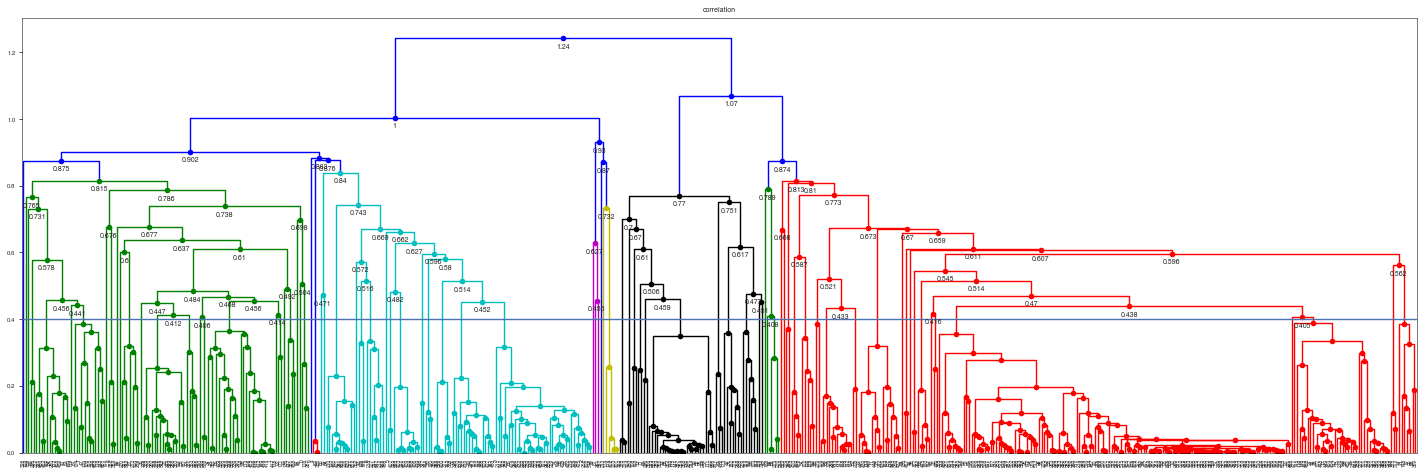

In [39]:
dists = plot_dendrogram(row_linkage, 0.4, "correlation")

In [40]:
clusters = hierarchy.fcluster(row_linkage, 0.1, criterion="distance")

In [41]:
print("n clusters: %s" % np.max(clusters))

n clusters: 223


In [42]:
cluster_map = pd.DataFrame.from_dict(dict(zip(list(corr.index), clusters)), orient="index")
cluster_map.columns = ["cluster"]
cluster_map.head()

,cluster
RUNX1,71
TFAP2A,55
Arnt,114
Ahr..Arnt,116
Ar,75


In [43]:
cluster_map.loc["BHLHE40"]

cluster    110
Name: BHLHE40, dtype: int64

## 3. plot clustered motif heatmap

In [44]:
colors = sns.husl_palette(np.max(clusters), s=0.75)
shuffle(colors)
lut = dict(zip(range(np.min(clusters), np.max(clusters)+1), colors))
row_colors = cluster_map["cluster"].map(lut)

In [45]:
cmap = sns.cubehelix_palette(8, start=.5, light=1, dark=0.25, hue=0.9, rot=-0.75, as_cmap=True)

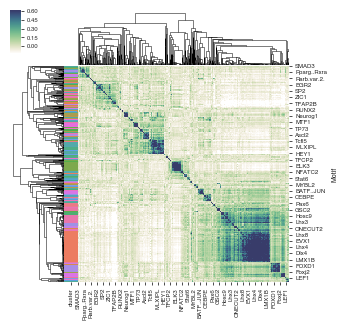

In [46]:
cg = sns.clustermap(corr, method="average", row_linkage=row_linkage, robust=True,
                    col_linkage=col_linkage, cmap=cmap, figsize=(5, 5), row_colors=row_colors,
                    linewidths=0, rasterized=True)
cg.savefig("Fig_S7A.pdf", bbox_inches="tight", dpi="figure")

In [47]:
cluster_map.to_csv("../../misc/02__mosbat/cluster_map.txt", sep="\t", index=True)

## 4. re-plot # bp covered and max coverage per biotype *after* clustering
note that i sent the cluster results to marta, who re-ran her coverage scripts using them, and i re-upload them in this notebook (so in real life there is a break between the above part and the following part of this notebook)

10/22/18 NOTE: MARTA NEEDS TO REDO THIS PART, OR WE CUT

In [49]:
cluster_cov["log_bp_covered"] = np.log(cluster_cov["numBPcovered"]+1)
cluster_cov["log_max_cov"] = np.log(cluster_cov["MaxCov"]+1)

cluster_cov_exp["log_bp_covered"] = np.log(cluster_cov_exp["numBPcovered"]+1)
cluster_cov_exp["log_max_cov"] = np.log(cluster_cov_exp["MaxCov"]+1)

NameError: name 'cluster_cov' is not defined

In [ ]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs (n=%s)" % len(enh_vals))
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs (n=%s)" % len(linc_vals), ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs (n=%s)" % len(dlnc_vals), ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs (n=%s)" % len(pc_vals), ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs (n=%s)" % len(dpc_vals), ax=ax)
ax.set_xlabel("log(# of bp covered, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((2.5,5))
fig.savefig("Fig_S7B.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_bp_covered"
xlabel = "log(# of bp covered)"
xlim = (2, 5)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_S7B_biotype_split.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(max coverage, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((0, 2.75))
fig.savefig("Fig_S7C.pdf", bbox_inches="tight", dpi="figure")

In [ ]:
# for each group, split into tissue-sp v dynamic v ubiquitous
idxs = list(range(0, 5))
promtypes = ["Enhancer", "intergenic", "protein_coding"]
names = ["eRNAs", "lincRNAs", "mRNAs"]
df = cluster_cov_exp
col = "log_max_cov"
xlabel = "log(max coverage)"
xlim = (0, 3)

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(7.2, 2))

for i, promtype, name in zip(idxs, promtypes, names):
    print("i: %s, promtype: %s, name: %s" % (i, promtype, name))
    ax = axarr[i]
    
    promtype_vals = df[df["PromType2"] == promtype]
    ts_vals = promtype_vals[promtype_vals["tss_type"] == "tissue-specific"][col]
    ub_vals = promtype_vals[promtype_vals["tss_type"] == "ubiquitous"][col]
    dy_vals = promtype_vals[promtype_vals["tss_type"] == "dynamic"][col]
    
    sns.kdeplot(data=ts_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dashed",
                label="tissue-sp.\n(n=%s)" % len(ts_vals), ax=ax)
    sns.kdeplot(data=ub_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="solid",
                label="ubiq.\n(n=%s)" % len(ub_vals), ax=ax)
    sns.kdeplot(data=dy_vals, cumulative=True, color=TSS_CLASS_PALETTE[promtype], linestyle="dotted",
                label="dynamic\n(n=%s)" % len(dy_vals), ax=ax)
    
    ax.set_title("%s (%s total)" % (name, len(promtype_vals)))
    ax.set_xlabel(xlabel)
    ax.legend(loc="bottom right")
    ax.set_xlim(xlim)
    
    if i == 0:
        ax.set_ylabel("cumulative density")
f.savefig("Fig_S7C_biotype_split.pdf", bbox_inches="tight", dpi="figure")

## 5. find good examples of lots of motifs and few motifs

In [50]:
motif_cov_exp.sort_values(by=["av_exp", "max_cov"], ascending=False).head()

,unique_id,cage_id,n_motifs,n_bp_cov,max_cov,avg_tf_tissue_sp,log_n_motifs,log_bp_cov,log_max_cov,log_avg_tf_tissue_sp,PromType2,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
25947,protein_coding__p1@FTL__chr19:49468563..494685...,"chr19:49468563..49468567,+",15,79,6,0.365316,2.772589,4.382027,1.945910,0.311386,protein_coding,3121.218149,0.951336,0.477238,550.0,ubiquitous
16417,protein_coding__p1@B2M__chr15:45003704..450037...,"chr15:45003704..45003724,+",26,75,9,0.348160,3.295837,4.330733,2.302585,0.298741,protein_coding,2383.028229,0.936382,0.523603,550.0,ubiquitous
2071,protein_coding__p1@RPS24__chr10:79793612..7979...,"chr10:79793612..79793631,+",22,71,14,0.417528,3.135494,4.276666,2.708050,0.348915,protein_coding,2335.912420,0.840886,0.231686,550.0,ubiquitous
26392,protein_coding__p1@RPL28__chr19:55897297..5589...,"chr19:55897297..55897303,+",33,91,17,0.437745,3.526361,4.521789,2.890372,0.363076,protein_coding,2328.610023,0.818471,0.297636,550.0,ubiquitous
13065,"div_pc__p1@TPT1__chr13:45915315..45915321,-","chr13:45915315..45915321,-",46,111,15,0.410342,3.850148,4.718499,2.772589,0.343832,div_pc,2151.582248,0.812062,0.285229,550.0,ubiquitous


In [51]:
clust_cov_exp_tss = cluster_cov_exp[cluster_cov_exp["PromType2"] != "Enhancer"]
chip_cov_exp_tss = chip_cov_exp[chip_cov_exp["PromType2"] != "Enhancer"]
tss_merge = clust_cov_exp_tss.merge(chip_cov_exp_tss, on=["unique_id", "cage_id"], suffixes=("_clust", "_chip"))
tss_merge = tss_merge[["unique_id", "n_motifs_chip", "n_motifs_clust", "max_cov_clust", "max_cov_chip", "av_exp_chip", "tissue_sp_all_chip", "tss_type_chip"]]
tss_merge.sample(5)

,unique_id,n_motifs_chip,n_motifs_clust,max_cov_clust,max_cov_chip,av_exp_chip,tissue_sp_all_chip,tss_type_chip
2926,protein_coding__p1@HOXC12__chr12:54348655..543...,4,7,2,2,0.661720,0.990700,moderate
13956,"intergenic__p1@ENST00000427039,p1@uc004bad.1__...",17,9,3,8,1.231294,0.909496,moderate
4427,"div_pc__p1@CTDSPL2__chr15:44719790..44719848,+",12,7,2,6,35.448854,0.801468,ubiquitous
8157,protein_coding__p1@SS18L1__chr20:60718785..607...,8,12,4,4,18.498767,0.818451,ubiquitous
14272,protein_coding__p1@CNTLN__chr9:17135016..17135...,6,2,1,2,11.297737,0.882307,ubiquitous


In [55]:
tss_merge[(tss_merge["unique_id"].str.contains("intergenic")) & (tss_merge["tss_type_chip"] == "ubiquitous")].sort_values(by=["max_cov_chip", "max_cov_clust"], ascending=False).head(100)

,unique_id,n_motifs_chip,n_motifs_clust,max_cov_clust,max_cov_chip,av_exp_chip,tissue_sp_all_chip,tss_type_chip
13109,intergenic__p1@LINC00265__chr7:39773160..39773...,28,7,3,14,4.408643,0.920643,ubiquitous
582,"intergenic__p1@ENST00000416301,p1@ENST00000444...",27,8,2,14,3.519481,0.860135,ubiquitous
10142,intergenic__p1@ENST00000453671__chr3:194304713...,20,8,3,13,4.764732,0.882028,ubiquitous
3030,intergenic__p1@LOC100506844__chr12:58329888..5...,32,2,1,13,10.773886,0.941015,ubiquitous
14366,intergenic__p1@LOC100506710__chr9:37079888..37...,23,7,2,12,10.223753,0.797721,ubiquitous
2324,intergenic__p1@LINC00467__chr1:211556107..2115...,25,9,4,11,13.950864,0.950737,ubiquitous
4946,"intergenic__p1@ERVK13-1__chr16:2723378..2723446,-",26,19,4,11,8.368928,0.820541,ubiquitous
6891,"intergenic__p1@BC067908__chr19:1876156..1876202,-",30,13,3,11,3.588906,0.939805,ubiquitous
467,"intergenic__p1@AGAP5,p1@BMS1P4__chr10:75490225...",14,5,2,11,6.799350,0.793227,ubiquitous
13525,"intergenic__p1@ENST00000517411,p1@ENST00000518...",26,5,2,11,9.121277,0.796281,ubiquitous


In [62]:
tss_merge[(tss_merge["unique_id"].str.contains("intergenic")) & (tss_merge["tss_type_chip"] == "tissue-specific") & (tss_merge["n_motifs_chip"] >= 1)].sort_values(by=["max_cov_chip", "max_cov_clust"], ascending=True).head(200)

,unique_id,n_motifs_chip,n_motifs_clust,max_cov_clust,max_cov_chip,av_exp_chip,tissue_sp_all_chip,tss_type_chip
60,intergenic__p2@ENST00000435106__chr10:10504285...,3,3,1,1,0.158632,0.985510,tissue-specific
325,intergenic__p1@C10orf136__chr10:44340748..4434...,1,2,1,1,0.049458,0.991142,tissue-specific
695,intergenic__p2@ENST00000534584__chr11:1049862....,1,1,1,1,0.087281,0.996794,tissue-specific
737,intergenic__p1@ENST00000534218__chr11:11164908...,1,3,1,1,0.082268,0.996460,tissue-specific
911,intergenic__p1@ENST00000416553__chr11:13112331...,1,2,1,1,0.078455,0.993645,tissue-specific
957,intergenic__p1@ENST00000528194__chr11:15932475...,1,1,1,1,0.003258,0.998182,tissue-specific
1009,"intergenic__p1@ENST00000501599,p1@ENST00000511...",1,3,1,1,0.035925,0.998055,tissue-specific
1132,intergenic__p1@ENST00000533575__chr11:38668018...,1,3,1,1,0.006733,0.998063,tissue-specific
1139,intergenic__p1@ENST00000528720__chr11:41736067...,1,1,1,1,0.011260,0.998058,tissue-specific
1933,"intergenic__p1@ENST00000534076,p1@uc001mfx.2__...",1,1,1,1,0.016597,0.997978,tissue-specific


## 3. look at conservation of nucleotides vs. motif coverage

In [48]:
res_dict = {}
df = fimo_phylop
nuc_cols = list(np.arange(-150, 150, step=1))

prev_max = 0
for max_motifs in [1, 10, 30, 86]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

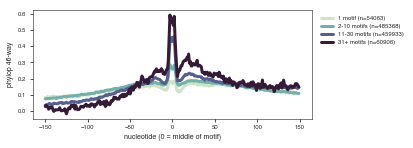

In [49]:
fig = plt.figure(figsize=(5,2))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 10: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           30: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 86: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-10 motifs", "11-30 motifs", "31+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.35, 1))
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")
fig.savefig("all_motifs_phylop.pdf", bbox_inches="tight", dpi="figure")

In [50]:
fimo_chip_phylop["n_ov"].max()

13

In [51]:
res_dict = {}
df = fimo_chip_phylop
nuc_cols = list(np.arange(-75, 75, step=1))

prev_max = 0
for max_motifs in [1, 4, 8, 13]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

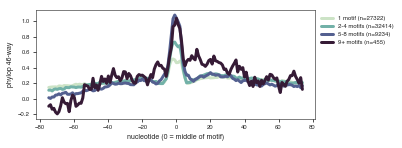

In [52]:
fig = plt.figure(figsize=(5,2))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 4: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           8: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 13: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-4 motifs", "5-8 motifs", "9+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.3, 1))
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")
fig.savefig("chip_motifs_phylop.pdf", bbox_inches="tight", dpi="figure")

In [53]:
fimo_clust_phylop["n_ov"].max()

13

In [54]:
res_dict = {}
df = fimo_clust_phylop
nuc_cols = list(np.arange(-75, 75, step=1))

prev_max = 0
for max_motifs in [1, 3, 6, 13]:
    sub = df[(df["n_ov"] > prev_max) & (df["n_ov"] <= max_motifs)]
    n_motifs = len(sub)
    nums = np.asarray(sub[nuc_cols])
    
    avg = np.nanmean(nums, axis=0)
    std = np.nanstd(nums, axis=0)
    
    y1 = avg - std
    y2 = avg + std
    
    res_dict[max_motifs] = {"n_motifs": n_motifs, "avg": avg, "y1": y1, "y2": y2}
    prev_max = max_motifs

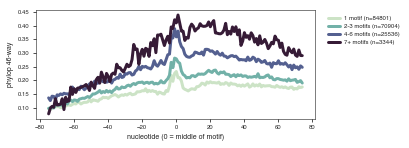

In [55]:
fig = plt.figure(figsize=(5,2))
palette = {1: sns.cubehelix_palette(4, start=.75, rot=-.75)[0], 3: sns.cubehelix_palette(4, start=.75, rot=-.75)[1], 
           6: sns.cubehelix_palette(4, start=.75, rot=-.75)[2], 13: sns.cubehelix_palette(4, start=.75, rot=-.75)[3]}
labels = ["1 motif", "2-3 motifs", "4-6 motifs", "7+ motifs"]

for n, label in zip(res_dict.keys(), labels):
    res = res_dict[n]
    n_motifs = res["n_motifs"]
    avg = res["avg"]
    y1 = res["y1"]
    y2 = res["y2"]
    # x = signal.savgol_filter(df["mean"], 15, 1)
    # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
    plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_motifs))
# plt.xlim((lower, upper))
# plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
# plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.325, 1))
plt.xlabel("nucleotide (0 = middle of motif)")
plt.ylabel("phylop 46-way")
fig.savefig("clustered_motifs_phylop.pdf", bbox_inches="tight", dpi="figure")